## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

## Create and preprocess the environment

### Create the environment

In [2]:
env = gym.make('Acrobot-v1')

In [3]:
dims = env.observation_space.shape[0]
actions = env.action_space.n

print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: 6. Actions: 3
Sample state: [ 0.99802554  0.06280956  0.99859256  0.05303714 -0.01001235 -0.09477711]


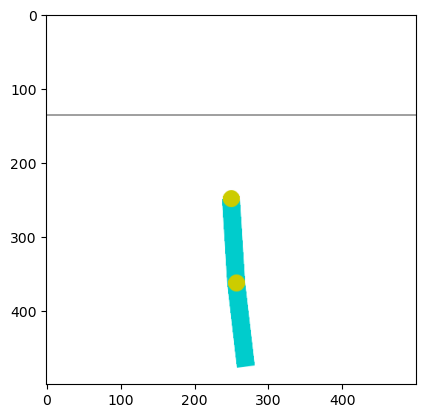

In [4]:
plt.imshow(env.render(mode='rgb_array'))

### Parallelize the environment

In [5]:
num_envs = os.cpu_count()
print(num_envs)

8


In [6]:
def create_env(env_name, seed):
    env = gym.make(env_name)
    seed_everything(env)
    return env

In [7]:
env_fns = [lambda: create_env('Acrobot-v1', seed=rank) for rank in range(num_envs)]
parallel_env = ParallelEnv(env_fns)

### Prepare the environment to work with PyTorch

In [8]:
class PreprocessEnv(ParallelWrapper):
    
    def __init__(self, env):
        ParallelWrapper.__init__(self, env)
    
    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()
    
    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)
     
    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [9]:
parallel_env = PreprocessEnv(parallel_env)

### Create the policy $\pi(s)$

In [11]:
policy = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, actions),
    nn.Softmax(dim=-1)
)

### Create the value network $v(s)$

In [12]:
value_net = nn.Sequential(
    nn.Linear(dims, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

## Implement the algorithm

</br>

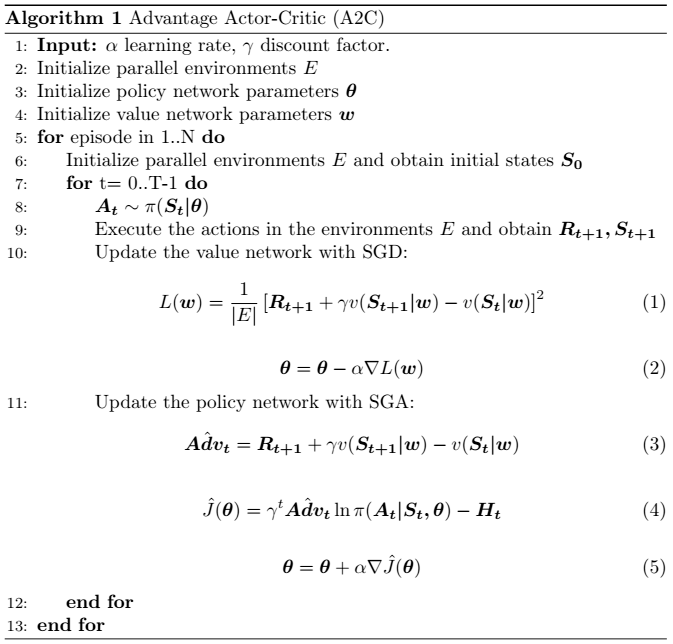

In [19]:
def actor_critic(policy, value_net, episodes, alpha=1e-4, gamma=0.99):
    policy_optim = AdamW(policy.parameters(), lr=alpha)
    value_optim = AdamW(value_net.parameters(), lr=alpha)
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}
    
    for episode in tqdm(range(1, episodes + 1)):
        state = parallel_env.reset()
        done_b = torch.zeros((num_envs, 1), dtype=torch.bool)
        ep_return = torch.zeros((num_envs, 1))
        I = 1. # to use to implement gamma power t
        
        while not done_b.all():
            action = policy(state).multinomial(1).detach() # to pick a single action based on probabilities
            next_state, reward, done, _ = parallel_env.step(action)
            
            value = value_net(state)
            target = reward + ~done * gamma * value_net(next_state).detach()
            critic_loss = F.mse_loss(value, target)
            
            value_net.zero_grad() # to delete the gradients stored in the value network
            critic_loss.backward() # triggers the backpropogation to compute the gradients
            value_optim.step() # to perform an update in the direction of the target
            
            advantage = (target - value).detach()
            probs = policy(state)
            log_probs = torch.log(probs + 1e-6)
            action_log_prob = log_probs.gather(1, action)
            entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
            actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
            actor_loss = actor_loss.mean()
            policy.zero_grad()
            actor_loss.backward()
            policy_optim.step()
            
            ep_return += reward
            done_b |= done
            state = next_state
            I = I * gamma
            
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return.mean().item())
        
    return stats
            

In [20]:
stats = actor_critic(policy, value_net, episodes=200)

100%|█████████████████████████████████████████| 200/200 [00:32<00:00,  6.16it/s]


## Show results

### Show execution stats

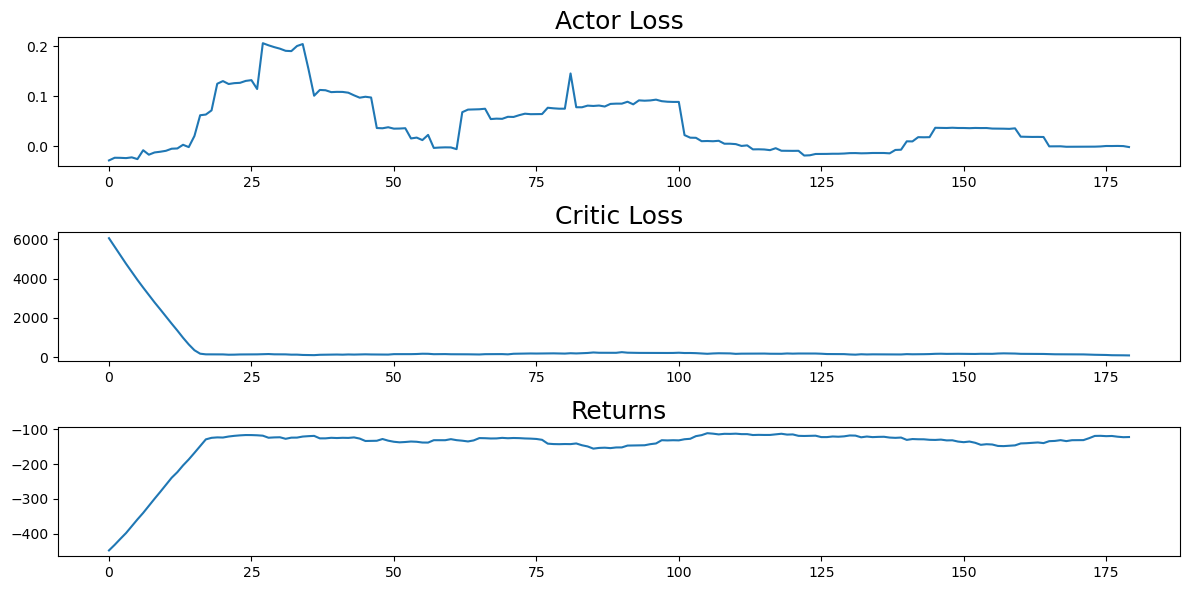

In [21]:
plot_stats(stats)

### Test the resulting agent

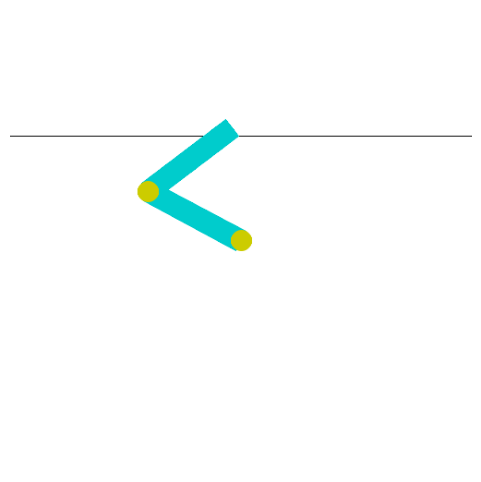

In [22]:
test_policy_network(env, policy, episodes=2)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch.13](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)